# Feature Extraction from Audio Chunks (Log-Mel Spectrogram)

In this notebook, I extracted **log-mel spectrogram features** from each 5-second preprocessed chunk (after human voice removal and trimming).

### Why Log-Mel Spectrogram?

The **log-mel spectrogram** captures:
- **Frequency** patterns over time (mel scale approximates human auditory perception)
- **Amplitude dynamics** in a compact form
- Crucial for modeling wildlife sounds and identifying bird vocalizations

### Processing Steps

1. Loaded each `.npz` chunk.
2. Computed mel spectrogram using `librosa.feature.melspectrogram()`.
3. Converted it to decibels using `librosa.power_to_db()`.


### Output

- Features stored as `.npz` files with shape `(64, 313)`.
- Ready-to-use input for both CNN and tabular models.

This step formed the **core representation of bird sounds** used for classification.


In [9]:
import os
import numpy as np
import librosa

def extract_log_mel_spectrograms(
    chunk_dir='processed/chunks',
    feat_dir='processed/feature',
    n_mels=64,
    n_fft=1024,
    hop_length=512,
    power=2.0,
    verbose=True 
):
    """
    For each .npz in chunk_dir containing 'y' (audio) and 'sr' (sample rate),
    compute a log-mel spectrogram and save it to feat_dir.
    """
    os.makedirs(feat_dir, exist_ok=True)

    for fname in sorted(os.listdir(chunk_dir)):
        if not fname.endswith('.npz'):
            continue

        # Load the chunk
        data = np.load(os.path.join(chunk_dir, fname))
        y, sr = data['y'], int(data['sr'])

        # Compute mel spectrogram (power)
        S = librosa.feature.melspectrogram(
            y=y,
            sr=sr,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels,
            power=power
        )
        # Convert to log scale (dB). Use ref=np.max for relative scaling.
        log_S = librosa.power_to_db(S, ref=np.max)

        # Save as compressed .npz
        out_name = fname.replace('.npz', '_mel.npz')
        out_path = os.path.join(feat_dir, out_name)
        np.savez_compressed(out_path,
                            mel=log_S.astype(np.float32),
                            sr=sr,
                            n_mels=n_mels,
                            n_fft=n_fft,
                            hop_length=hop_length)

        if verbose:
            print(f"Saved {out_name} (shape: {log_S.shape})")

if __name__ == "__main__":
    extract_log_mel_spectrograms()


Saved CSA18786_5_mel.npz (shape: (64, 313))
Saved CSA35130_10_mel.npz (shape: (64, 313))
Saved CSA35130_15_mel.npz (shape: (64, 313))
Saved CSA35130_20_mel.npz (shape: (64, 313))
Saved CSA35130_25_mel.npz (shape: (64, 313))
Saved CSA35130_30_mel.npz (shape: (64, 313))
Saved CSA35130_35_mel.npz (shape: (64, 313))
Saved CSA35130_5_mel.npz (shape: (64, 313))
Saved CSA35146_10_mel.npz (shape: (64, 313))
Saved CSA35146_100_mel.npz (shape: (64, 313))
Saved CSA35146_105_mel.npz (shape: (64, 313))
Saved CSA35146_110_mel.npz (shape: (64, 313))
Saved CSA35146_115_mel.npz (shape: (64, 313))
Saved CSA35146_120_mel.npz (shape: (64, 313))
Saved CSA35146_125_mel.npz (shape: (64, 313))
Saved CSA35146_130_mel.npz (shape: (64, 313))
Saved CSA35146_135_mel.npz (shape: (64, 313))
Saved CSA35146_140_mel.npz (shape: (64, 313))
Saved CSA35146_145_mel.npz (shape: (64, 313))
Saved CSA35146_15_mel.npz (shape: (64, 313))
Saved CSA35146_150_mel.npz (shape: (64, 313))
Saved CSA35146_155_mel.npz (shape: (64, 313))


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os

def visualize_mel_file(file_path):
    """
    Load and analyze a log-mel spectrogram saved in .npz format.
    Assumes the file contains: 'mel', 'sr', 'hop_length', 'n_mels'.
    """
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return

    # Load .npz
    data = np.load(file_path)
    mel = data['mel']
    sr = int(data['sr'])
    hop_length = int(data['hop_length'])
    n_mels, n_frames = mel.shape
    times = np.arange(n_frames) * hop_length / sr
    freqs = np.linspace(0, sr / 2, n_mels)

    # Print summary
    print(f"File: {os.path.basename(file_path)}")
    print(f"Mel shape: {n_mels} mel bands × {n_frames} frames")
    print(f"Sample rate: {sr} Hz")
    print(f"Hop length: {hop_length} samples → ~{hop_length / sr:.3f} sec/frame")
    print(f"dB range: min={mel.min():.1f}, max={mel.max():.1f}, mean={mel.mean():.1f}, std={mel.std():.1f}")

    # Plot: Heatmap
    plt.figure(figsize=(10, 4))
    plt.pcolormesh(times, freqs, mel, shading='auto', cmap='magma')
    plt.colorbar(label='dB')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Log-Mel Spectrogram')
    plt.tight_layout()
    plt.show()

    # Plot: Average energy per band
    plt.figure(figsize=(6, 4))
    avg_band = mel.mean(axis=1)
    plt.plot(freqs, avg_band)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Avg dB')
    plt.title('Average Energy per Mel Band')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot: Histogram of values
    plt.figure(figsize=(6, 4))
    plt.hist(mel.flatten(), bins=50, color='skyblue', edgecolor='black')
    plt.xlabel('dB')
    plt.ylabel('Count')
    plt.title('Distribution of Mel Spectrogram Values')
    plt.tight_layout()
    plt.show()


File: CSA35130_15_mel.npz
Mel shape: 128 mel bands × 313 frames
Sample rate: 32000 Hz
Hop length: 512 samples → ~0.016 sec/frame
dB range: min=-80.0, max=0.0, mean=-44.6, std=7.9


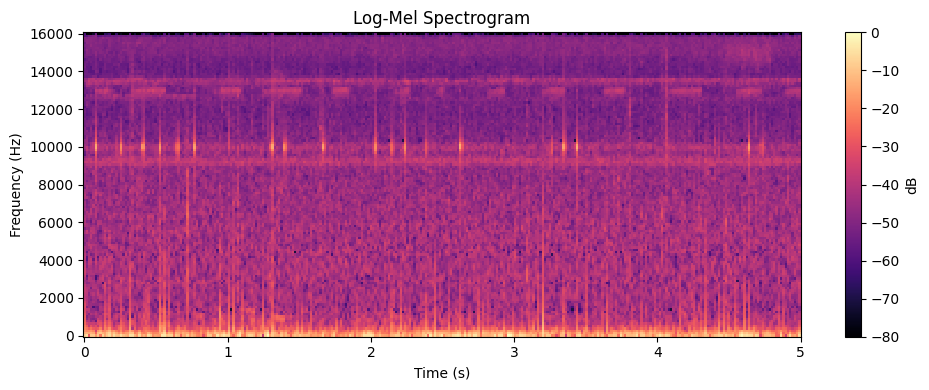

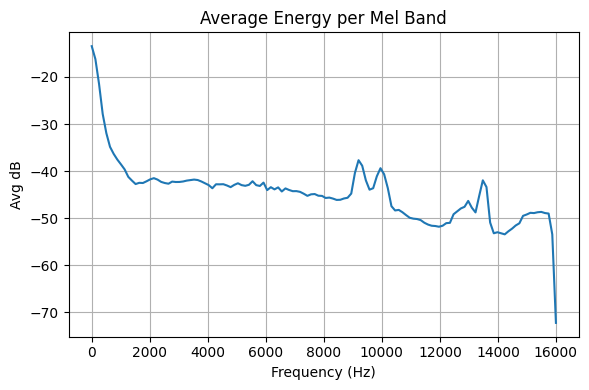

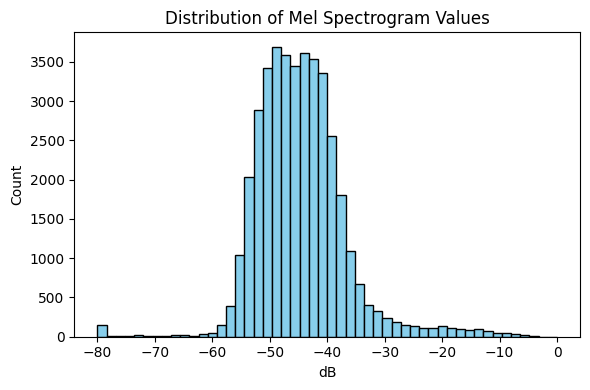

In [6]:
visualize_mel_file("/Users/istiak/Desktop/birdCLEF2025/processed/feature/CSA35130_15_mel.npz")


### Efficient Audio Preprocessing and Feature Extraction Pipeline
The notebook below combines the entire preprocessing pipeline into one efficient process to save disk space and streamline computation. Instead of saving intermediate outputs like raw waveforms, trimmed audio, or chunked clips, this pipeline:

- Loads .ogg audio files from the train_audio/ subfolders
- Removes human voice segments using webrtcvad
- Chunks the non-speech audio into 5-second clips
- Directly extracts log-mel spectrograms from these chunks in memory
- Saves only the final mel-spectrograms as compressed .npz files in processed/feature/

This approach significantly reduces disk usage, improves preprocessing speed, and retains only the useful model input for training.

In [10]:
import os
import numpy as np
import librosa
import webrtcvad

def process_ogg_to_mel(
    input_root='data/train_audio/',
    output_dir='processed/feature',
    chunk_duration_sec=5,
    frame_duration_ms=30,
    sr=32000,
    n_mels=64,
    n_fft=1024,
    hop_length=512,
    power=2.0,
    aggressiveness=2,
    verbose=True
):
    os.makedirs(output_dir, exist_ok=True)
    vad = webrtcvad.Vad(aggressiveness)

    for root, _, files in os.walk(input_root):
        for file in files:
            if not file.endswith(".ogg"):
                continue
            file_path = os.path.join(root, file)
            try:
                y, _ = librosa.load(file_path, sr=sr)
            except Exception as e:
                print(f"Error loading {file}: {e}")
                continue

            # === Trim human speech ===
            frame_size = int(sr * frame_duration_ms / 1000)
            trimmed_audio = []
            for i in range(0, len(y), frame_size):
                frame = y[i:i + frame_size]
                if len(frame) < frame_size:
                    frame = np.pad(frame, (0, frame_size - len(frame)), mode='constant')
                pcm = (frame * 32768).astype(np.int16).tobytes()
                if not vad.is_speech(pcm, sr):
                    trimmed_audio.extend(frame[:len(frame)])

            trimmed_audio = np.array(trimmed_audio, dtype=np.float32)
            chunk_size = chunk_duration_sec * sr
            total_chunks = len(trimmed_audio) // chunk_size

            if total_chunks == 0:
                continue

            base = os.path.splitext(file)[0]
            if verbose:
                print(f"{file}: trimmed → {len(trimmed_audio)} samples → {total_chunks} chunks")

            # === Chunk & Convert to log-mel ===
            for i in range(total_chunks):
                start = i * chunk_size
                end = start + chunk_size
                chunk = trimmed_audio[start:end]

                # Mel spectrogram
                mel = librosa.feature.melspectrogram(
                    y=chunk, sr=sr,
                    n_fft=n_fft, hop_length=hop_length,
                    n_mels=n_mels, power=power
                )
                log_S = librosa.power_to_db(mel, ref=np.max)

                # Save final mel
                end_time = (i + 1) * chunk_duration_sec
                out_name = f"{base}_{end_time}_mel.npz"
                np.savez_compressed(os.path.join(output_dir, out_name),
                                    mel=log_S.astype(np.float32),
                                    sr=sr,
                                    n_mels=n_mels,
                                    n_fft=n_fft,
                                    hop_length=hop_length)
                if verbose:
                    print(f"Saved: {out_name}")

# Run the full end-to-end pipeline
process_ogg_to_mel()


XC537250.ogg: trimmed → 313920 samples → 1 chunks
Saved: XC537250_5_mel.npz
XC409344.ogg: trimmed → 247680 samples → 1 chunks
Saved: XC409344_5_mel.npz
XC381962.ogg: trimmed → 1324800 samples → 8 chunks
Saved: XC381962_5_mel.npz
Saved: XC381962_10_mel.npz
Saved: XC381962_15_mel.npz
Saved: XC381962_20_mel.npz
Saved: XC381962_25_mel.npz
Saved: XC381962_30_mel.npz
Saved: XC381962_35_mel.npz
Saved: XC381962_40_mel.npz
XC312930.ogg: trimmed → 381120 samples → 2 chunks
Saved: XC312930_5_mel.npz
Saved: XC312930_10_mel.npz
XC567307.ogg: trimmed → 663360 samples → 4 chunks
Saved: XC567307_5_mel.npz
Saved: XC567307_10_mel.npz
Saved: XC567307_15_mel.npz
Saved: XC567307_20_mel.npz
iNat74451.ogg: trimmed → 505920 samples → 3 chunks
Saved: iNat74451_5_mel.npz
Saved: iNat74451_10_mel.npz
Saved: iNat74451_15_mel.npz
XC424701.ogg: trimmed → 753600 samples → 4 chunks
Saved: XC424701_5_mel.npz
Saved: XC424701_10_mel.npz
Saved: XC424701_15_mel.npz
Saved: XC424701_20_mel.npz
XC379461.ogg: trimmed → 967680 

In [11]:
import os

def count_files(folder_path, extension=None):
    count = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if extension:
                if file.endswith(extension):
                    count += 1
            else:
                count += 1
    return count

# Example usage:
folder = "/Users/istiak/Desktop/birdCLEF2025/processed/feature"
total_files = count_files(folder, extension=".npz")  # you can change extension or remove it
print(f"Total .ogg files: {total_files}")


Total .ogg files: 121255
